# Learning Soft Constraints using Apprenticeship Learning

## General Setup and Imports

Propagate code changes into notebook

In [74]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [75]:
%matplotlib inline

In [76]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvas
# allow us to re-use the framework from the src directory
import sys, os
sys.path.append(os.path.abspath(os.path.join('../')))
from collections import namedtuple, defaultdict


In [77]:
import max_ent.examples.grid_3_by_3 as G
from max_ent.gridworld import Directions
#%matplotlib notebook      commenting this out enables inline plotting
np.random.seed(123)
from max_ent.algorithms import mmp as MMP
from max_ent.algorithms import mmp_helper as H

## Gridworld Setup

The following function sets up the gridworld environment. The gridworld is a 2D grid with a start and goal state. The fig object is also returned now as the last parameter, and if this is saved you can view the images of the world. 

In [78]:
Demonstration = namedtuple('Demonstration', ['trajectories', 'policy'])

In [79]:
def create_world(title, blue, green, cs=[], ca=[], cc=[], start=0, goal=2, vmin=-50, vmax=10):
    n_cfg = G.config_world(blue, green, cs, ca, cc, goal)
    n = n_cfg.mdp

    # Generate demonstrations and plot the world
    demo = G.generate_trajectories(n.world, n.reward, n.start, n.terminal) 
    #test_demo = Demonstration(demo.trajectories[0:2], demo.policy)
    vmin = -50
    vmax = 10
    G.plot_world(title, n, n_cfg.state_penalties,
           n_cfg.action_penalties, n_cfg.color_penalties,
           demo, n_cfg.blue, n_cfg.green, vmin=vmin, vmax=vmax)
    return n, n_cfg, demo

### Nominal World

{'vmin': -50, 'vmax': 10, 'cmap': <matplotlib.colors.LinearSegmentedColormap object at 0x10c2a2dd0>}


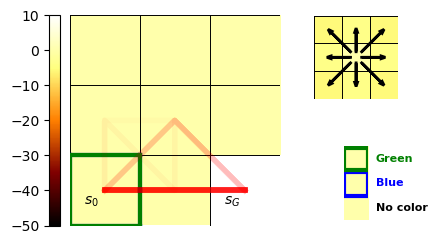

In [80]:
blue = [0]  # blue states
green = [0]  # green states

n, n_cfg, demo_n = create_world('Nominal', blue, green)

### Constrained World Creation

{'vmin': -50, 'vmax': 10, 'cmap': <matplotlib.colors.LinearSegmentedColormap object at 0x10c2a2dd0>}


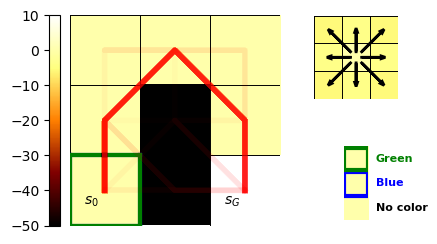

In [81]:
cs = [1, 4]  # constrained states
ca = []  # constrained actions
cc = []  # constrained colors

c, c_cfg, demo_c = create_world('Constrained', blue, green, cs, ca, cc)

## Algorithm

### Algorithm Specific Imports

In [82]:
import max_ent.optim as O
from max_ent.algorithms import rl as RL
from numpy.linalg import norm
import math
import max_ent.gridworld.trajectory as T
import scipy.special 

### Parameters

In [83]:
discount=0.9
clip_grad_at=10
lr=0.3
max_iter=500
burn_out=50
eps=1e-4
log=None
initial_omega=None
init = O.Constant(1e-6)
optim = O.ExpSga(lr=lr, clip_grad_at=clip_grad_at)
start = [0]
burnout = 500

In [84]:
nominal_rewards = n.reward
world = c.world
terminal = c.terminal
trajectories = demo_c.trajectories
p_transition = world.p_transition
features = world.phi

In [85]:
from collections import namedtuple, defaultdict
Demonstration = namedtuple('Demonstration', ['trajectories', 'policy'])

### Learning

Order of actions:   left, right, up, down, up-left, up-right, down-left, down-right

In [71]:
reward_final, sample_tjs = MMP.mmp(world, nominal_rewards, world.p_transition, world.phi,
                      terminal, trajectories, optim, init, discount,
                      max_iter=max_iter, burnout=50, eps=eps, log=log, initial_omega=initial_omega)

Iteration:  0
Iteration:  1
Iteration:  2
margin:  1.572277664334977
Iteration:  3
margin:  1.347504508465401
Iteration:  4
margin:  1.3343856389819073
Iteration:  5
margin:  1.334296344756915
Iteration:  6
margin:  1.3341790584019737
Iteration:  7
margin:  1.3341587193666329
Iteration:  8
margin:  1.3341058517513837
Iteration:  9
margin:  1.3338560699143616
Iteration:  10
margin:  1.3338210536940536
Iteration:  11
margin:  1.3337832789621424
Iteration:  12
margin:  1.3337042730364255
Iteration:  13
margin:  1.3334916821923153
Iteration:  14
margin:  1.333490912886767
Iteration:  15
margin:  1.333183835211571
Iteration:  16
margin:  1.3328582999667593
Iteration:  17
margin:  1.3327221350953364
Iteration:  18
margin:  1.332680874596152
Iteration:  19
margin:  1.3323631572759298
Iteration:  20
margin:  1.3323463582441302
Iteration:  21
margin:  1.3322663625689353
Iteration:  22
margin:  1.331954906176188
Iteration:  23
margin:  1.3316033249093853
Iteration:  24
margin:  1.331479213485339

In [31]:
H.fe_from_trajectories(features, trajectories, discount)

array([0.10449   , 0.0756    , 0.64159112, 0.884241  , 0.046512  ,
       0.65564802, 0.04536   , 0.7379019 , 0.0343359 , 0.009     ,
       0.116154  , 0.976041  , 0.62098553, 0.        , 0.7958169 ,
       0.        , 0.70768251, 3.12118994, 0.        , 0.10449   ])

In [30]:
H.fe_from_trajectories(features, sample_tjs, discount)

array([1.35482318, 0.39379302, 0.19207255, 1.65320642, 0.67823561,
       0.50304548, 0.70913346, 1.41432972, 0.37270761, 0.76459841,
       0.53568932, 1.77785036, 0.96023831, 0.78186235, 1.02771278,
       0.6751618 , 0.74823371, 5.91652386, 0.        , 1.35482318])

In [72]:
H.fe_from_trajectories(features, sample_tjs, discount)

array([1.56343157, 0.41424029, 0.19839426, 1.6012729 , 0.64205565,
       0.46943679, 0.67644945, 1.30360069, 0.34557003, 0.77001492,
       0.52115776, 1.68985978, 1.01699166, 0.80304835, 0.95773195,
       0.68622563, 0.76942159, 5.65102006, 0.        , 1.56343157])

Plotting function to visualize trajectories at any point in algorithm.

{'vmin': -50, 'vmax': 10, 'cmap': <matplotlib.colors.LinearSegmentedColormap object at 0x10c2a2dd0>}


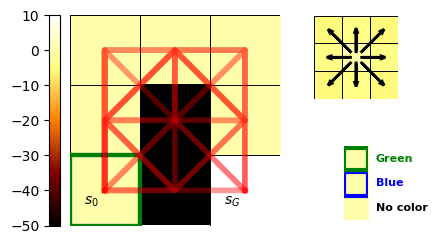

In [73]:
learned_mdp = G.MDP(c.world, reward_final, c.terminal, c.start)
demo_l = G.generate_trajectories(c.world, reward_final, c.start, c.terminal)
p = G.plot_world('Learned Constrained', learned_mdp, c_cfg.state_penalties,
           n_cfg.action_penalties, n_cfg.color_penalties, 
              demo_l, c_cfg.blue, c_cfg.green, vmin=-50, vmax=10)

{'vmin': -50, 'vmax': 10, 'cmap': <matplotlib.colors.LinearSegmentedColormap object at 0x110a52410>}


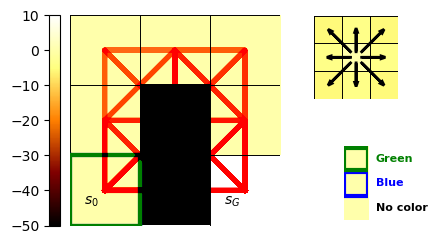

In [57]:
n_cfg = G.config_world(blue, green, cs, ca, cc, 2)
n = n_cfg.mdp


G.plot_world('test', c, c_cfg.state_penalties,
           n_cfg.action_penalties, n_cfg.color_penalties,
           Demonstration(sample_tjs, None), n_cfg.blue, n_cfg.green, vmin=-50, vmax=10);

In [22]:
learned_params = G.learn_constraints(n.reward, c.world, c.terminal, demo_c.trajectories) 

terminal [2]
e_features [0.12 0.09 1.   1.   0.06 0.94 0.06 0.94 0.05 0.01 0.16 1.1  0.99 0.
 1.   0.   1.   4.14 0.   0.12]
MAE(best):  0.587891118400720
MAE(best):  0.086415820611459
MAE(best):  0.017125448346003
MAE(best):  0.015761221971998
MAE(best):  0.015761221971998
Finished with MAE(best):  0.015761221971998


{'vmin': -50, 'vmax': 10, 'cmap': <matplotlib.colors.LinearSegmentedColormap object at 0x1099591d0>}


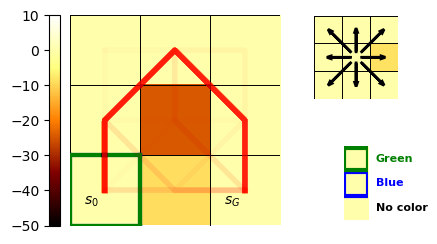

In [23]:
learned_mdp = G.MDP(c.world, learned_params.reward, c.terminal, c.start)
demo_l = G.generate_trajectories(c.world, learned_params.reward, c.start, c.terminal)
p = G.plot_world('Learned Constrained', learned_mdp, learned_params.state_weights, 
              learned_params.action_weights, learned_params.color_weights, 
              demo_l, c_cfg.blue, c_cfg.green, vmin=-50, vmax=10)
p.savefig('examplemmp.pdf')

In [25]:
q_function, v_function = value_iteration(p_transition, learned_params.reward, discount)
policy = stochastic_policy_from_q_value(world, q_function) #get policy from running RL with initial reward function
policy_exec = stochastic_policy_adapter(policy)
#policy_list.append(policy)

In [26]:
sample_tjs = T.generate_trajectories(1000, world, policy_exec, initial, terminal)

In [28]:
demo_joe = Demonstration(sample_tjs, policy)

{'vmin': -50, 'vmax': 10, 'cmap': <matplotlib.colors.LinearSegmentedColormap object at 0x1099591d0>}


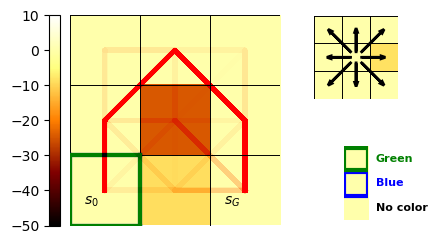

In [29]:
p = G.plot_world('Learned Constrained', learned_mdp, learned_params.state_weights, 
              learned_params.action_weights, learned_params.color_weights, 
              demo_joe, c_cfg.blue, c_cfg.green, vmin=-50, vmax=10)

In [35]:
learned_params.reward[3, 5,:]

array([ -5.6568544 , -14.57849459,   4.34314475,  -5.65685425,
       -30.14219191,  -5.65685425,  -5.65685429,  -5.65685425,
        -5.65685433])